In [1]:
import rosbag
import numpy as np
import sys
import csi_utils.constants as constants
import csi_utils.transform_utils as transform_utils
import csi_utils.pipeline_utils as pipeline_utils
import csi_utils.comp_utils as comp_utils
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.cm import ScalarMappable

In [2]:
# Define variables to store your data
comp = np.load("192.168.43.1-157.npy")
apply_nts = True
idx = 0
valid_tx_ant = [0,1,2,3]

In [3]:
def draw_channel_image_4x4(channel_1, channel_2):
    print("afad")
    num_tx_slots = channel_1.shape[2]
    num_rx_slots = channel_1.shape[1]
    tx_ant_labels = [f"Tx Ant {i}" for i in range(num_tx_slots)]
    rx_ant_labels = [f"Rx Ant {i}" for i in range(num_rx_slots)]
    fig, axs = plt.subplots(num_tx_slots*2, num_rx_slots, figsize=(24, 24),
                            gridspec_kw={'height_ratios': [1, 0.7] * num_tx_slots})
    # add tick for phase plot
    y_tick_positions = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    y_tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    amplitude_1 = (np.abs(channel_1))
    amplitude_2 = (np.abs(channel_2))
    min_amp = min(np.min(amplitude_1), np.min(amplitude_2))
    max_amp = max(np.max(amplitude_1), np.max(amplitude_2))
    phase_1 = np.unwrap(np.angle(channel_1))
    phase_2 = np.unwrap(np.angle(channel_2))
    min_phase = min(np.min(phase_1), np.min(phase_2))
    max_phase = max(np.max(phase_1), np.max(phase_2))
    print(min_phase, max_phase)
    for i in range(0, num_tx_slots*2, 2):
        for j in range(num_rx_slots):
            if i == 0:
                # Place Rx antenna labels at the top
                axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
            if j == 0:
                # Place Tx antenna labels on the left 
                axs[i, j].text(-0.2, 0, f"Tx Ant {i//2}", va='center', ha='center',
                               rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
            # plot magnitude
            axs[i, j].set_xlabel("Subcarrier indices")
            axs[i, j].set_ylabel("Magnitude (dB)")
            axs[i, j].set_ylim(min_amp-10, max_amp+10)
            # axs[i, j].plot(20*np.log10(np.abs(channel_1[:, j, i//2])),
            #                label="LOS")
            axs[i, j].plot((np.abs(channel_1[:, j, i//2])),
                           label="LOS")
            # axs[i, j].plot(20*np.log10(np.abs(channel_2[:, j, i//2])),
                        #    label="NLOS")
            axs[i, j].legend()
            # plot phase
            axs[i+1, j].set_xlabel("Subcarrier indices")
            axs[i+1, j].set_ylabel("Phase (deg)")
            axs[i+1, j].set_ylim(min_phase, max_phase)
            axs[i+1, j].set_yticks(y_tick_positions)
            axs[i+1, j].set_yticklabels(y_tick_labels)
            # don't wrap 
            # axs[i+1, j].plot(np.angle(channel_1[:, j, i//2]),
            #                  label="LOS")
            # axs[i+1, j].plot(np.angle(channel_2[:, j, i//2]),
            #                  label="NLOS")
            axs[i+1, j].plot(np.unwrap(np.angle(channel_1[:, j, i//2])),
                             label="LOS")
            axs[i+1, j].plot(np.unwrap(np.angle(channel_2[:, j, i//2])),
                             label="NLOS2")
            axs[i+1, j].legend() 
    fig.set_tight_layout(True)   
    plt.savefig('40 157 los vs nlos.png')
    plt.show()
   

def draw_amplitude_4x4(channel, figure_title=""):
    print("afad")
    num_tx_slots = channel.shape[2]
    num_rx_slots = channel.shape[1]
    fig, axs = plt.subplots(num_tx_slots, num_rx_slots, figsize=(24, 24),
                            sharey=True, layout='constrained')
    fig.suptitle(figure_title, fontsize=24)
    # add tick for phase plot
    amplitude = (np.abs(channel))
    min_amp = np.min(amplitude)
    max_amp = np.max(amplitude)
    for i in range(num_tx_slots):
        for j in range(num_rx_slots):
            if i == 0:
                # Place Rx antenna labels at the top
                axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
            if j == 0:
                # Place Tx antenna labels on the left 
                axs[i, j].text(-0.2, 0.5, f"Tx Ant {i}", va='center', ha='center',
                               rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
                
            # plot magnitude
            axs[i, j].set_xlabel("Subcarrier indices")
            axs[i, j].set_ylabel("Magnitude")
            axs[i, j].set_ylim(min_amp-10, max_amp+10)
            axs[i, j].plot((np.abs(channel[:, j, i])),
                           label="LOS")
            axs[i, j].legend()
    fig.set_tight_layout(True)   
    # plt.savefig('40 157 los vs nlos.png')
    plt.show()

In [4]:
def draw_amplitudes_4x4(bag, figure_title="", average=False, fig=None, axs=None, show=True, min_a=None, max_a=None):
    print("afad")
    num_tx_slots = 4
    num_rx_slots = 4
    tx_ant_labels = [f"Tx Ant {i}" for i in range(num_tx_slots)]
    rx_ant_labels = [f"Rx Ant {i}" for i in range(num_rx_slots)]
    if (fig is None):
        fig, axs = plt.subplots(num_tx_slots, num_rx_slots, figsize=(24, 24),
                            sharey=True, layout='constrained')
        fig.suptitle(figure_title, fontsize=24)
    # add tick for phase plot
    y_tick_positions = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    y_tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    # amplitude = (np.abs(channel))
    min_amp = 1000
    max_amp = -1000
    # phase = np.unwrap(np.angle(channel))
    # min_phase = np.min(phase)
    # max_phase = np.max(phase)
    
    for i in range(num_tx_slots):
        for j in range(num_rx_slots):
                if i == 0:
                    # Place Rx antenna labels at the top
                    axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
                if j == 0:
                # Place Tx antenna labels on the left 
                    axs[i, j].text(-0.2, 0.5, f"Tx Ant {i}", va='center', ha='center',
                rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
                k = 20
                if not average:
                    for data in bag:
                        channel = pipeline_utils.extract_csi(data[1], None, False, valid_tx_ant)
                        amplitude = (np.abs(channel))
                        min_amp = min(np.min(amplitude), min_amp)
                        max_amp = max(np.max(amplitude), max_amp)
                        # axs[i, j].plot((np.abs(channel[:, j, i])), label="l")
                        axs[i, j].plot((amplitude[:, j, i]), label="l")
                        k += 1
                        if k == 30:
                            break
                else:
                    totalValues = None
                    for data in bag:
                        channel = pipeline_utils.extract_csi(data[1], None, False, valid_tx_ant)
                        if totalValues is None:
                            totalValues = channel
                        else:
                            totalValues += channel
                        k += 1
                        if k == 30:
                            break
                    amplitude = (np.abs(totalValues))
                    min_amp = min(np.min(amplitude), min_amp)
                    max_amp = max(np.max(amplitude), max_amp)
                    # axs[i, j].plot((np.abs(channel[:, j, i])), label="l")
                    axs[i, j].plot((amplitude[:, j, i]), label="l")
                     

                    
                # plot magnitude
                axs[i, j].set_xlabel("Subcarrier indices")
                axs[i, j].set_ylabel("Magnitude")
                if (min_a != None):
                     min_amp = min_a
                if (max_a != None):
                     max_amp = max_a
                mi, ma = axs[i, j].get_ylim()
                axs[i, j].set_ylim(min(mi,min_amp-10), max(ma, max_amp+10))

                # axs[i, j].legend()
    fig.set_tight_layout(True)   
    # plt.savefig('40 157 los vs nlos.png')
    if show:
        plt.show()

In [5]:
def compare_amplitudes_4x4(bags, figure_title=""):
    fig, axs = plt.subplots(4, 4, figsize=(24, 24),
                            sharey=True, layout='constrained')
    fig.suptitle(figure_title, fontsize=24)
    for bag in bags:
        print("drawing bag")
        draw_amplitudes_4x4(bag, "", True, fig, axs, False)
    for i in range(4):
        for j in range(4):
            axs[i, j].legend([f"Location {k}" for k in range(1, 6)])
    plt.show()

In [6]:
# headon = rosbag.Bag("../HeadOn.bag")
# ninetydeg = rosbag.Bag("../90deg2.bag")
# fortyfive = rosbag.Bag("../45deg.bag")
# nfortyfive = rosbag.Bag("../n45deg.bag")
import tqdm
#smooth over last n packets according to algo
smoothing_window = 1
#aoa search space
theta_space = np.linspace(-np.pi/2,np.pi/2,360)
#tof search space
tof_space = np.linspace(-40,40,240)

#antenna position (interleaved x-y), see antennas.md
rx_pos = np.asarray([0,  0,
    0,  -0.06,
    0,  -0.03,
    0,  -0.09]).reshape((-1,2))
channels = {}
times = {}
aoas = {}
rssis = {}
profs = {}
aoa_sensors = {}


In [7]:
def get_angle_profiles(bag, algorithm, subcarriers = range(0, 50)):
  """Returns a list of [(time, [angles], [profile])] for each packet"""
  print("ALGORITHM:", algorithm)
  num = 0
  data = []
  aoa_sensor = None
  if algorithm == "music":
    aoa_sensor = transform_utils.music_aoa_sensor_1d(rx_pos, theta_space, smoothing_window)
  elif algorithm == "aoa":
    aoa_sensor = transform_utils.aoa_sensor_1d(rx_pos, theta_space, smoothing_window)
  elif algorithm == "fft":
    aoa_sensor = transform_utils.fft_aoa_sensor(rx_pos, theta_space, smoothing_window)
  for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      csi = pipeline_utils.extract_csi(msg, comp)
      if num == 1:
        print(csi.shape)
      #assuming this does not change
      res = aoa_sensor.run(csi,(msg.chan,msg.bw*1e6), subcarriers=subcarriers)
      num += 1
      data.append((t.to_sec(), theta_space * 180 / np.pi, res[1]))
  print("Packets:", num)
  return data

def plot_angle_profiles(data, title, savename=None):
  """Plots a list of [(time, [angles], [profile])]"""
  fig, ax = plt.subplots()
  plt.title(title)
  plt.ylabel("Angle (degrees)")
  plt.xlabel("Time")
  for time, angles, profile in data:
    ax.scatter([time] * len(angles), angles, c=profile, s=10)
  if savename is not None:
    plt.savefig(savename)
  plt.show()

ALGORITHM: music


311it [00:00, 2945.19it/s]


(50, 4, 4)
Packets: 311
ALGORITHM: music


0it [00:00, ?it/s]

(50, 4, 4)


311it [00:00, 3111.96it/s]

Packets: 311


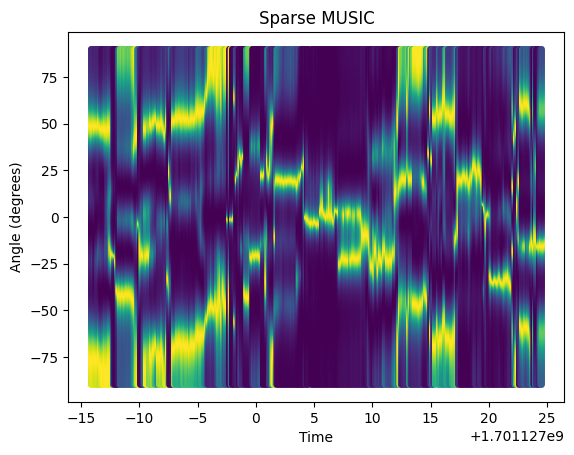

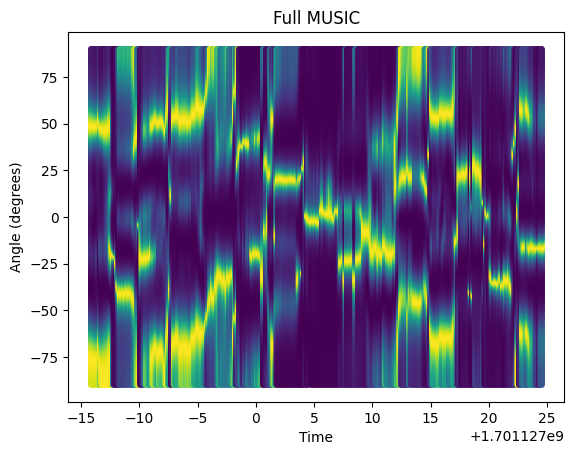

In [8]:
rotationData = rosbag.Bag("rotationData.bag")
musicData1 = get_angle_profiles(rotationData, "music", [0, 10, 20, 30, 40, 49])
musicData2 = get_angle_profiles(rotationData, "music")
# aoaData = get_angle_profiles(rotationData, "aoa")
# clippedMusic = []
# for i in range(len(musicData)):
#   row = musicData[i][2].copy()
#   row[row < 1] = 0
#   clippedMusic.append((musicData[i][0], musicData[i][1], row))
# clippedAoa = []
# for i in range(len(aoaData)):
#   row = aoaData[i][2].copy()
#   row[row < 1] = 0
#   clippedAoa.append((aoaData[i][0], aoaData[i][1], row))
# clippedCombined = []
# for i in range(len(musicData)):
#   clippedCombined.append((musicData[i][0], musicData[i][1], clippedMusic[i][2] * clippedMusic[i][2]))

# differences = []
# for i in range(len(musicData)):
#   differences.append((musicData[i][0], musicData[i][1], np.isclose(musicData[i][2], aoaData[i][2], rtol=0.3)))


# spotfi = get_angle_profiles(rotationData, "fft")
plot_angle_profiles(musicData1, "Sparse MUSIC", "Sparse MUSIC.png")
plot_angle_profiles(musicData2, "Full MUSIC")
# plt.savefig('music.png')
# plot_angle_profiles(aoaData, "AOA")
# plot_angle_profiles(clippedMusic, "Clipped Music")
# plot_angle_profiles(clippedAoa, "Clipped AOA")
# plot_angle_profiles(clippedCombined, "Combined")
# plot_angle_profiles(differences, "Differences")
# plot_angle_profiles(spotfi, "FFT")

time_visualizeprofile(rotationData, "Rotation Data Over Time (1d AOA)", "aoa")

ALGORITHM: aoa


311it [00:00, 3263.28it/s]

(50, 4, 4)
Packets: 311


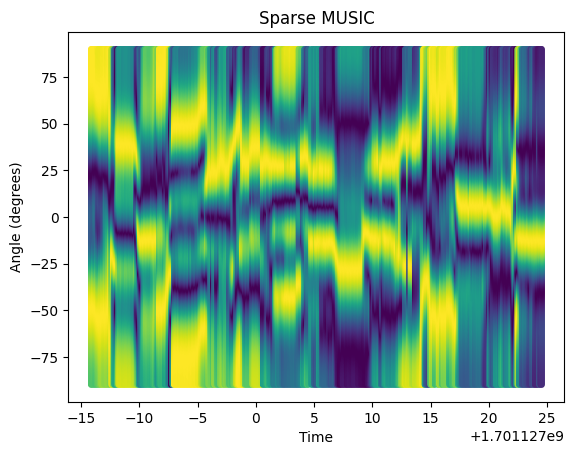

In [15]:
plot_angle_profiles(get_angle_profiles(rotationData, "aoa", range(0, 10)), f"Sparse MUSIC")

In [10]:
# Load the ROS bag file
# bag_1 = rosbag.Bag("../2023-11-10-15-38-09.bag")
# no_antennae = rosbag.Bag("../los_no_r_antennae_no_t_antennae.bag")
# no_rx_antennae = rosbag.Bag("../los_no_rx_antennae.bag")
# no_rx_antennae_2 = rosbag.Bag("../los_no_rx_2.bag")
# both_antennae_low = rosbag.Bag("../los_lowpower.bag")
# both_antennae = rosbag.Bag("../los_both_antennae.bag")
# los_nonatt = rosbag.Bag("../los_nonattenuated.bag")
# los_att = rosbag.Bag("../los_attenuated.bag")
# los_no_blocker = rosbag.Bag("../los_no_signal_blocker.bag")
# los_blocker = rosbag.Bag("../los_signal_blocker.bag")
foil = rosbag.Bag("../foil.bag")
foil2 = rosbag.Bag("../foil2.bag")
nofoil = rosbag.Bag("../nofoil.bag")
onefoil = rosbag.Bag("../one_foil.bag")
onefoil2 = rosbag.Bag("../one_foil2.bag")
test = rosbag.Bag("../test.bag")
test2 = rosbag.Bag("../test2.bag")
test3 = rosbag.Bag("../test3.bag")
calibration_data = rosbag.Bag("../new_calibration_data.bag")
headon = rosbag.Bag("../HeadOn.bag")
ninetydeg = rosbag.Bag("../90degrees.bag")
nlosbags = []
for k in range(1, 6):
    filename = f"../nlos_{k}.bag"
    nlosbags.append(rosbag.Bag(filename))
# bag_2 = rosbag.Bag('/home/sora/wifi_ws/rosbag_res/20 11 nlos.bag')

FileNotFoundError: [Errno 2] No such file or directory: '../foil.bag'

In [ ]:
# no_antennae_channel = pipeline_utils.extract_csi(next(no_antennae.read_messages())[1], None, apply_nts, valid_tx_ant)
# no_rx_antennae_channel = pipeline_utils.extract_csi(next(no_rx_antennae.read_messages())[1], None, apply_nts, valid_tx_ant)
# both_antennae_channel = pipeline_utils.extract_csi(next(both_antennae.read_messages())[1], None, apply_nts, valid_tx_ant)
# i = 0
# for ((_, na, _), (_, nra, _), (_, ba, _)) in zip(no_antennae, no_rx_antennae, both_antennae):
#     draw_amplitude_4x4(pipeline_utils.extract_csi(na, None, apply_nts, valid_tx_ant), "3.76m LOS, No Antennae")
#     draw_amplitude_4x4(pipeline_utils.extract_csi(nra, None, apply_nts, valid_tx_ant), "3.76 LOS, No Rx Antennae")
#     draw_amplitude_4x4(pipeline_utils.extract_csi(ba, None, apply_nts, valid_tx_ant), "3.76 LOS, All Antennae")
#     i += 1
#     if (i == 10):
        # break
print(type(onefoil))
print(type(nofoil))
compare_amplitudes_4x4([test, test2, test3])
# draw_amplitudes_4x4(test)
# compare_amplitudes_4x4(nlosbags, "4.88m nlos")
# draw_amplitudes_4x4(nofoil, "4.88m No Foil", True)
# draw_amplitudes_4x4(onefoil2, "4.88m OneFoil")
# draw_amplitudes_4x4(foil, "4.88m Foil")
# draw_amplitudes_4x4(foil, "4.88m Foil2")


# draw_amplitudes_4x4(both_antennae, "3.76m LOS, Both Antennae")
# draw_amplitudes_4x4(both_antennae_low, "4.88m LOS low power, Both Antennae")
# draw_amplitudes_4x4(no_rx_antennae, "3.76m LOS, No Rx Antennae")
# draw_amplitudes_4x4(no_rx_antennae_2, "3.76m LOS, No Rx Antennae 3")
# draw_amplitudes_4x4(no_antennae, "3.76m LOS, No Antennae")
# draw_amplitude_4x4(no_antennae_channel, "3.76m LOS, No Antennae")
# draw_amplitude_4x4(no_rx_antennae_channel, "3.76 LOS, No Rx Antennae")
# draw_amplitude_4x4(no_rx_antennae_channel, "3.76 LOS, All Antennae")

In [ ]:
bearings = rosbag.Bag("../bearingTest5.bag")

def get_aoa(data, degrees=True):
    if degrees:
        return 180/np.pi * data[1].aoa[0]
    return data[1].aoa[0]

def graph_aoa(bag):
    times = []
    angles = []
    for data in bag:
        angles.append(get_aoa(data))
        times.append(data[1].header.stamp.secs + 0.000000001 * data[1].header.stamp.nsecs - bag.get_start_time())
    plt.scatter(times, angles, s=7)
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.show()
# print(bearings.get_start_time())
# for data in bearings:
#     # pass
#     # print(data)
#     # print(get_aoa(data))
#     print(data)
#     # print(data[1].header.stamp.secs)
#     # channel = pipeline_utils(data[1], None, False, valid_tx_ant)
#     # amplitude = (np.abs(channel))
graph_aoa(bearings)

In [ ]:
def graph_angle(bagfile):
    return